# Notebook Interface

This tool provides functionality for optimising a portfolio of renewable energy contracts, i.e. choosing what fraction of capacity to contract from set a generators in order to best match the combined generation profile with a load profile. Additionally, there is functionality for modelling battery operation, load flexibility, calculating bills, and visualising key results.

This notebook interface is intended to be easy to use for people with minimal Python experience. Key inputs are presented as various widgets, including dropdown menus, multi-select menus and text fill boxes. 

To get started, you will need to know a few things about Jupyter Notebooks:
1. You'll need to run the cells in order, from top to bottom, in order for the code to work as intended. This ensures that all the necessary packages are present, data is loaded and variables are initialised. 
2. To run cells, all you need to do is click the small 'play button' (a small solid triangle in the top menu bar if you're using Jupyter Lab online) after you've clicked into the cell you want to run. You can also select 'Run Selected Cell' from the dropdown menu if you prefer, or use the hotkey "Shift+Enter" or "Shift+Return". 
3. To make multiple selections in the multi-select menus available, use either "Shift+click" (to select all options between two items in the list, inclusive) or "Command+click" to select multiple separate items. 

For an introduction to Jupyter Notebooks you can start with the Jupyter welcome tour in [this notebook](https://jupyter.org/try-jupyter/notebooks/?path=notebooks/Intro.ipynb).

For help or to give any feedback, please email Ellie [here](e.kallmier@unsw.edu.au).

In [ ]:
# ------------------------------ Packages & Files ------------------------------
import copy
from pathlib import Path

import ipywidgets as widgets
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn.objects as so
from IPython.display import HTML, display
from plotly.subplots import make_subplots

from ppa_analysis import (
    advanced_settings,
    battery,
    bill_calc,
    charts,
    firming_contracts,
    helper_functions,
    hybrid,
    import_data,
    load_flex,
    tariffs,
    user_inputs,
)

INFO: Using Python-MIP package version 1.15.0


## 1. Load, generation and price data selection

Start by running the following cell and using the widgets to define your modelling scenario.

In [7]:
# ------------------------------ Initialise the input collector ----------------
input_collector = user_inputs.launch_input_collector()

/Users/elliekallmier/Desktop/everything/RA_Work/247/247_ppa/ppa_analysis
data_caches/yearly_data_files


Dropdown(description='Year:', options=('2020', '2021'), value='2020')

Dropdown(description='Generator region:', options=('QLD1', 'NSW1', 'VIC1', 'SA1', 'TAS1'), value='QLD1')

Dropdown(description='Load region:', options=('QLD1', 'NSW1', 'VIC1', 'SA1', 'TAS1'), value='QLD1')

Dropdown(description='Load data file:', options=('(57) Sewerage treatment FN', '(54) Office building FN', '(20…

SelectMultiple(description='Generators:', index=(0, 1, 2, 3), options=('CSPVPS1: PHOTOVOLTAIC FLAT PANEL', 'CO…

Dropdown(description='Time series interval:', options=('60',), value='60')

Output()

In [8]:
generator_data_editor = user_inputs.launch_generator_data_editor(input_collector)

Output()

## 2. Tariffs

Now choose the tariff you want to use in this model from the dropdown menu below.

Tariffs have been collected from publicly available records shared by each DNSP in Australia. If you have selected "Retail" as your firming option, you will also be able to edit additional charges here. 

In [9]:
tariff_collector = user_inputs.tariff_options_collector(input_collector)

if input_collector["firming_contract_type"].value == "Retail":
    extra_charges_collector = user_inputs.launch_extra_charges_collector()
else:
    extra_charges_collector = {}

Dropdown(description='Tariff name:', options=('ELTOUDT1 ToU Demand East', 'ELTOUDT2 ToU Demand East', 'ELTOUDT…

### Bringing it all together:

Run the cells below to collect and combine data based on your inputs and selections.

In [10]:
# Now collect the given inputs and combine data into useful formats here:
gen_data_editor_dict = helper_functions.convert_gen_editor_to_dict(
    generator_data_editor
)
gen_info = helper_functions.get_all_lcoes(gen_data_editor_dict)
combined_data = user_inputs.collect_and_combine_data(
    input_collector, tariff_collector, extra_charges_collector
)

In [11]:
# Running this cell will show you the first 5 rows of the data that has been
# collected and combined based on your inputs above:

combined_data.head()

,Load,CSPVPS1: PHOTOVOLTAIC FLAT PANEL,COOPGWF1: WIND - ONSHORE,DDSF1: PHOTOVOLTAIC FLAT PANEL,KSP1: PHOTOVOLTAIC FLAT PANEL,RRP,AEI,Firming price
DateTime,,,,,,,,
2020-01-01 01:00:00,1.082778,0.0,82.488179,0.0,0.0,52.119075,0.785886,52.119075
2020-01-01 02:00:00,1.142356,0.0,77.129198,0.0,0.0,51.180633,0.857561,51.180633
2020-01-01 03:00:00,1.067444,0.0,80.869461,0.0,0.0,51.841654,0.856539,51.841654
2020-01-01 04:00:00,1.031942,0.0,68.187557,0.0,0.0,51.313714,0.857571,51.313714
2020-01-01 05:00:00,1.038692,0.0,58.687316,0.0,0.0,48.306674,0.861483,48.306674


### See the data

By running the cell below, you will generate two charts that show you average seasonal daily profiles for both your chosen load profile and generators.

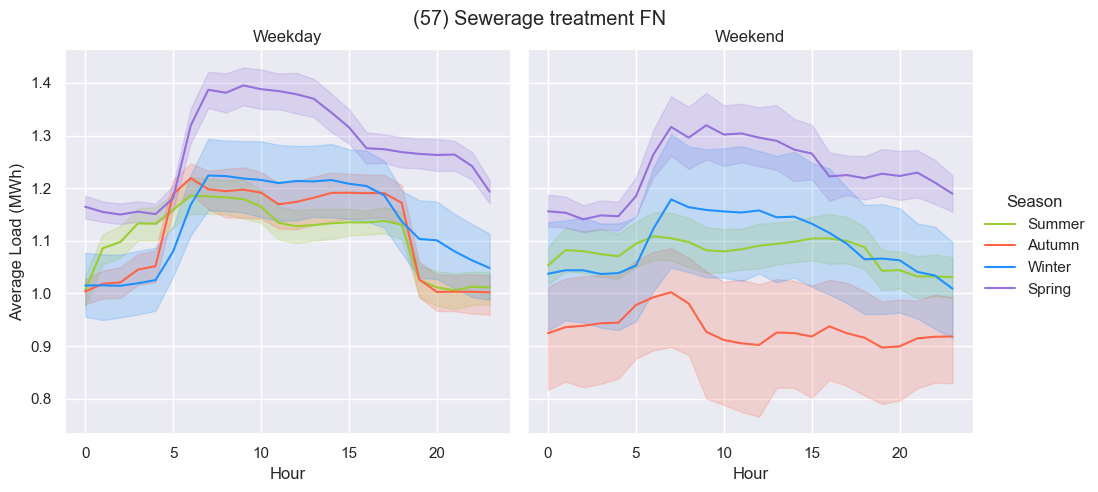

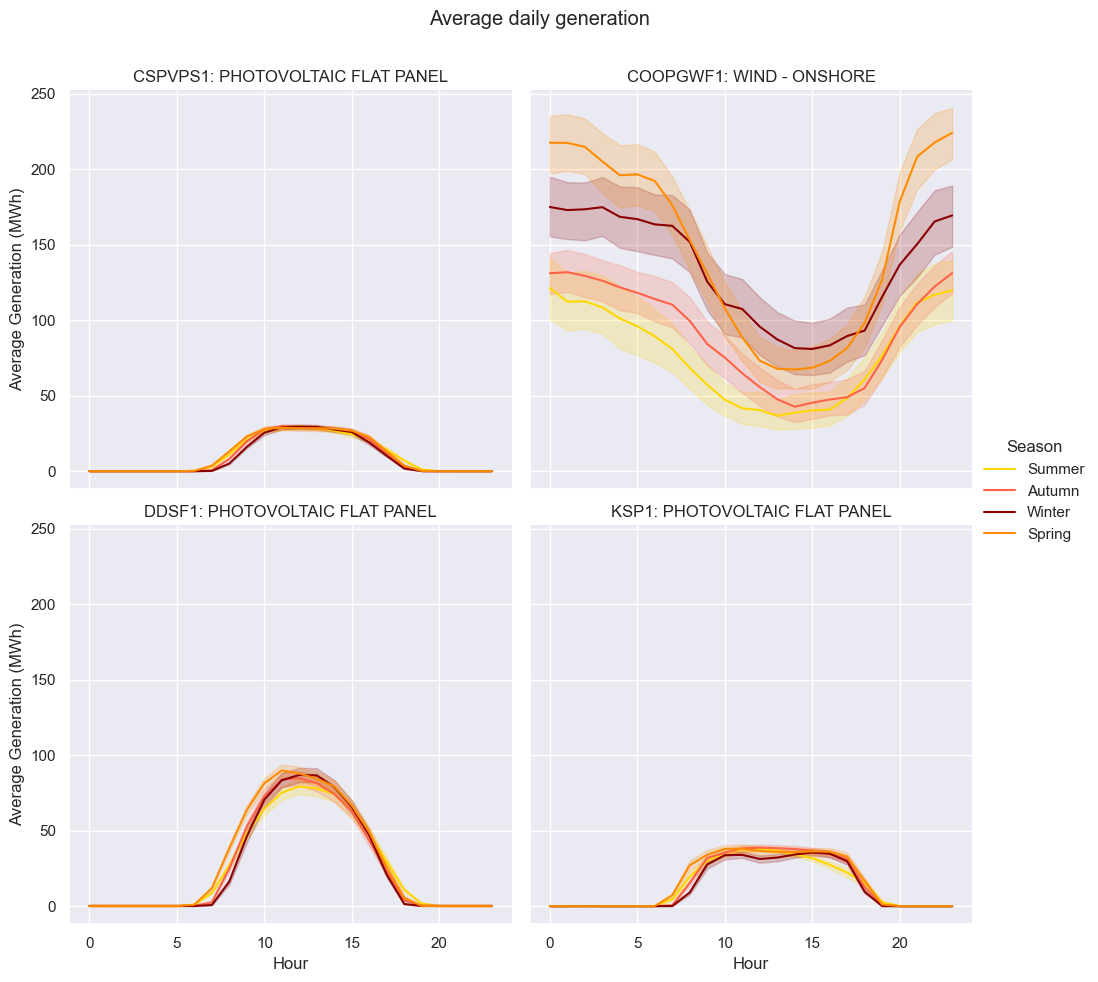

In [12]:
# Characteristic charts:
charts.plot_avg_seasonal_load(
    combined_data,
    input_collector["load_region"].value,
    input_collector["load_data_file"].value,
)
charts.plot_avg_seasonal_generation(
    combined_data,
    input_collector["load_region"].value,
    [gen for gen in generator_data_editor.keys() if gen != "out"],
)

## 3. Run the contract optimisation model

The following cells takes your chosen data and runs a linear optimisation to minimise the cost of firming under your selected contract details.

In [13]:
# Now calculate the hybrid percentage here:
opt_hybrid, percentages = hybrid.create_hybrid_generation(
    input_collector["contract_type"].value,
    input_collector["contract_amount"].value,
    combined_data,
    gen_info,
    input_collector["redefine_period"].value,
    input_collector["matching_percentile"].value,
)


combined_data["Hybrid"] = opt_hybrid["Hybrid"].copy()
combined_data["Contracted Energy"] = opt_hybrid["Contracted Energy"].copy()

combined_data["Delivered Hybrid"] = np.minimum(
    combined_data["Contracted Energy"], combined_data["Hybrid"]
)

In [14]:
# Here you can look at the first 5 rows of the data after finding the optimal contract mix:
combined_data.head()

,Load,CSPVPS1: PHOTOVOLTAIC FLAT PANEL,COOPGWF1: WIND - ONSHORE,DDSF1: PHOTOVOLTAIC FLAT PANEL,KSP1: PHOTOVOLTAIC FLAT PANEL,RRP,AEI,Firming price,Hybrid,Contracted Energy,Delivered Hybrid
DateTime,,,,,,,,,,,
2020-01-01 01:00:00,1.082778,0.0,82.488179,0.0,0.0,52.119075,0.785886,52.119075,0.527524,0.527524,0.527524
2020-01-01 02:00:00,1.142356,0.0,77.129198,0.0,0.0,51.180633,0.857561,51.180633,0.493252,0.493252,0.493252
2020-01-01 03:00:00,1.067444,0.0,80.869461,0.0,0.0,51.841654,0.856539,51.841654,0.517172,0.517172,0.517172
2020-01-01 04:00:00,1.031942,0.0,68.187557,0.0,0.0,51.313714,0.857571,51.313714,0.436069,0.436069,0.436069
2020-01-01 05:00:00,1.038692,0.0,58.687316,0.0,0.0,48.306674,0.861483,48.306674,0.375314,0.375314,0.375314


### Take a look at your contract results:

The cells below will generate charts that summarise the optimal mix of renewable sources in the scenario defined by your inputs.

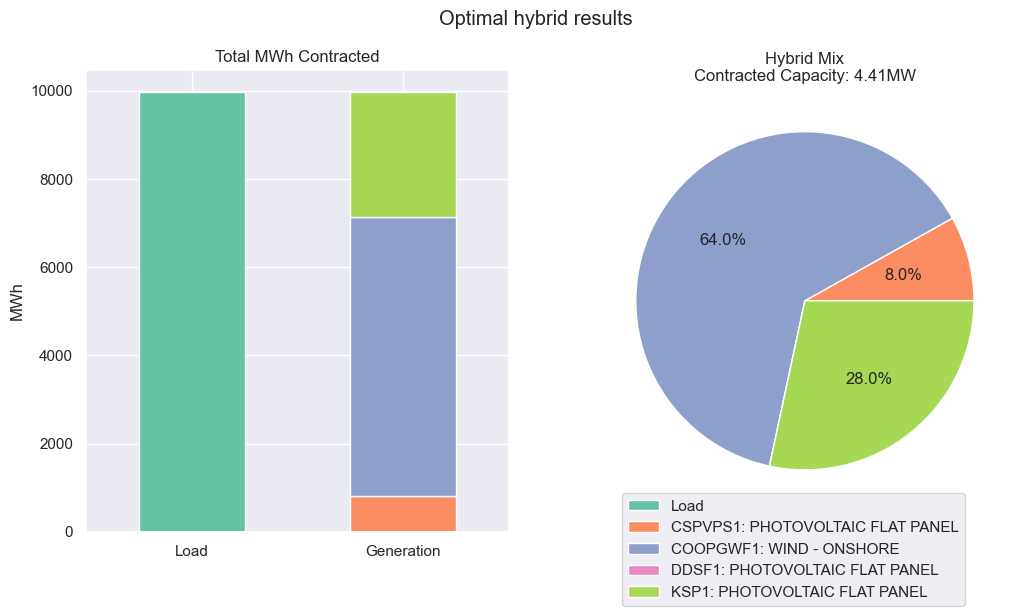

In [15]:
generator_capacities = {
    key: generator_data_editor[key]["Nameplate Capacity (kW)"].value
    for key in generator_data_editor
    if key != "out"
}
charts.plot_hybrid_results(combined_data, percentages, generator_capacities)

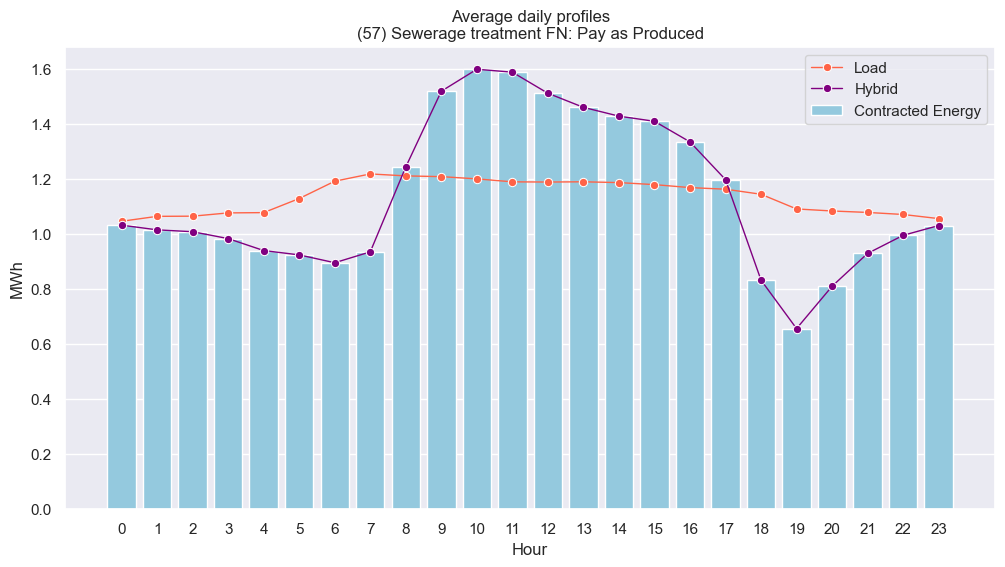

In [16]:
charts.plot_contract_samples(
    combined_data,
    input_collector["load_data_file"].value,
    input_collector["contract_type"].value,
    ["Load"],
)

## 4. Calculate your bill results

Now you can find out the costs associated with your defined contract, broken down by component and time period.

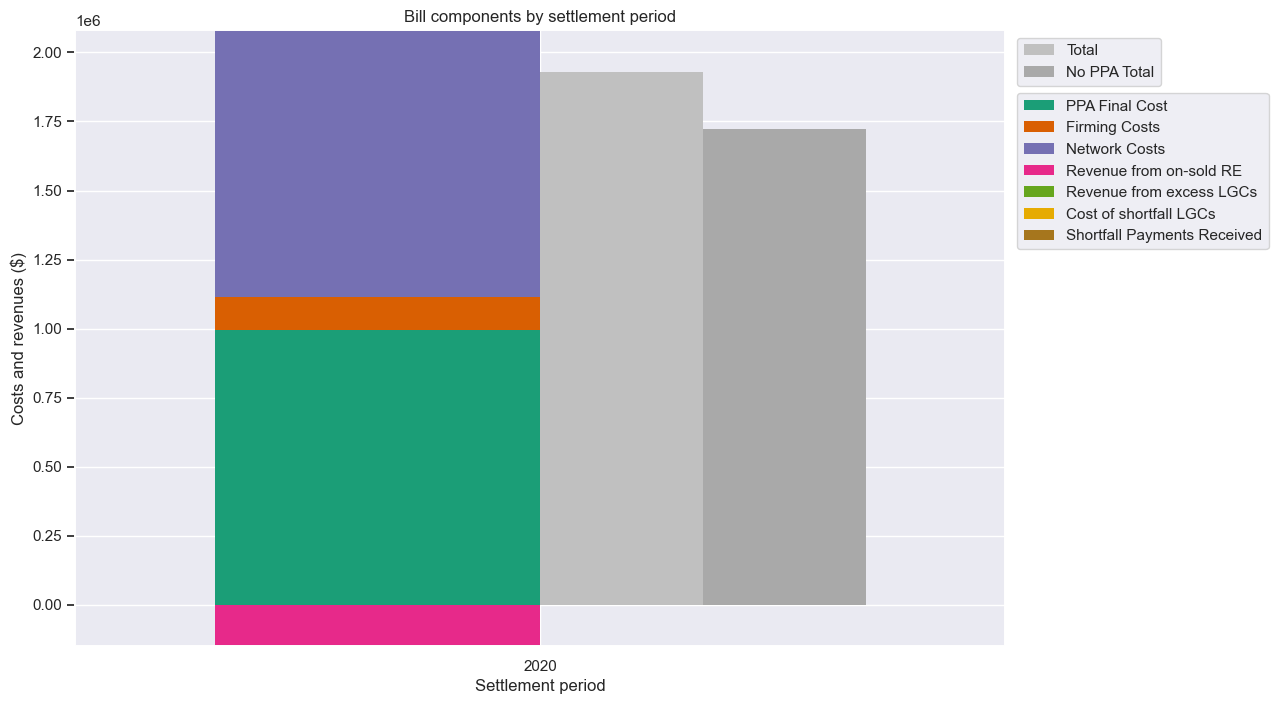

In [17]:
tariff_details = {
    "Network": helper_functions.get_selected_tariff(
        tariff_collector, extra_charges_collector, False
    ),
    "Retail": helper_functions.get_selected_tariff(
        tariff_collector, extra_charges_collector
    ),
}

bill = bill_calc.calculate_bill(
    volume_and_price=combined_data,
    settlement_period=input_collector["settlement_period"].value,
    contract_type=input_collector["contract_type"].value,
    firming_type=input_collector["firming_contract_type"].value,
    tariff_details=tariff_details,
    strike_price=input_collector["strike_price"].value,
    lgc_buy_price=input_collector["lgc_buy_price"].value,
    lgc_sell_price=input_collector["lgc_sell_price"].value,
    shortfall_penalty=input_collector["shortfall_penalty"].value,
    guaranteed_percent=input_collector["contract_amount"].value,
    excess_price=input_collector["excess_price"].value,
    indexation=input_collector["indexation"].value,
    index_period=input_collector["index_period"].value,
    floor_price=input_collector["floor_price"].value,
)

wholesale_bill = bill_calc.calculate_wholesale_bill(
    timeseries_data=combined_data,
    settlement_period=input_collector["settlement_period"].value,
    lgc_buy_price=input_collector["lgc_buy_price"].value,
)

charts.plot_bill_components(
    bill_results=bill.astype(float),
    wholesale_bill_results=wholesale_bill.astype(float),
    settlement_period=input_collector["settlement_period"].value,
)

In [18]:
# This cell generated a cash-flow waterfall chart:
charts.plot_cashflow(bill_results=bill.astype(float))

## 5. Add a behind-the-meter battery:

Run the cells below to define the battery size and run a linear optimisation model that uses excess renewable generation stored by the battery to minimise the cost of firming under your selected contract.

In [19]:
battery_input_collector = user_inputs.launch_battery_input_collector()

In [20]:
# Battery
rated_power_capacity = battery_input_collector["rated_power_capacity"].value
size_in_mwh = battery_input_collector["size_in_mwh"].value

with_a_battery = battery.run_battery_optimisation(
    timeseries_data=combined_data,
    rated_power_capacity=rated_power_capacity,
    size_in_mwh=size_in_mwh,
)

Cbc3007W No integer variables


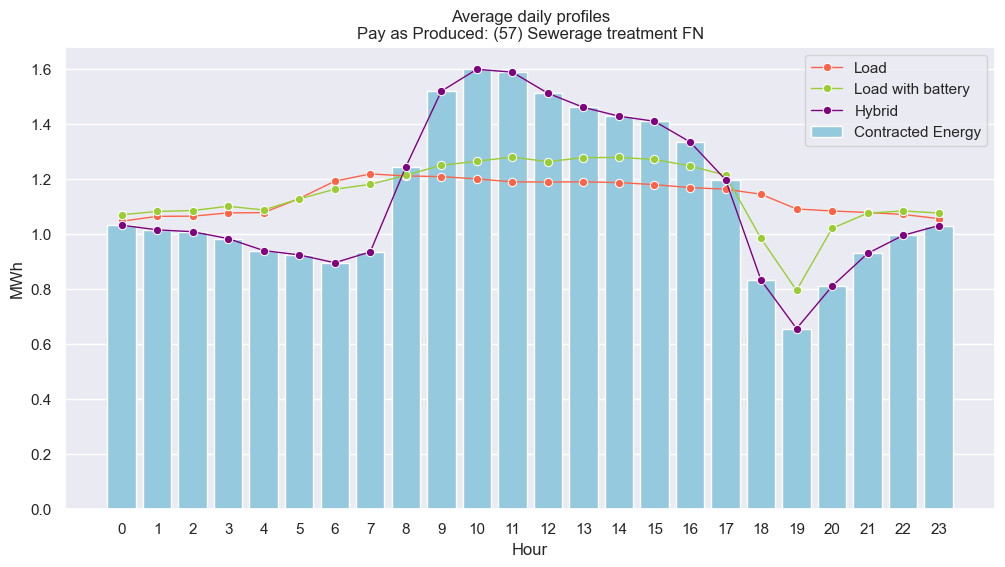

In [21]:
charts.plot_contract_samples(
    combined_data,
    input_collector["contract_type"].value,
    input_collector["load_data_file"].value,
    ["Load", "Load with battery"],
)

## 6. Add load flexibility

The following cells allow you to define a scenario with a given level of load flexibility, modelled as demand shifting. 

In [22]:
# Load Flex
flex_input_collector = user_inputs.launch_flex_input_collector()

In [23]:
combined_data = helper_functions.get_weekends(
    combined_data, input_collector["load_region"].value
)

combined_data, load_flex_details = load_flex.daily_load_shifting(
    timeseries_data=combined_data,
    base_load_quantile=flex_input_collector["base_load_quantile"].value,
    raise_price=flex_input_collector["raise_price"].value,
    lower_price=flex_input_collector["lower_price"].value,
    ramp_up_price=flex_input_collector["ramp_up"].value,
    ramp_down_price=flex_input_collector["ramp_down"].value,
)

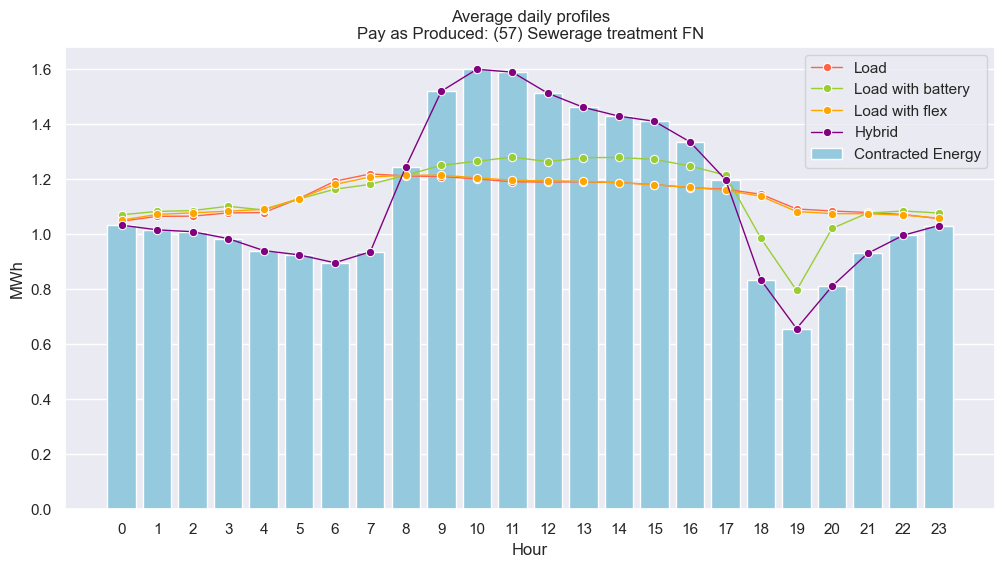

In [24]:
# Plot the average daily profiles with both a battery and load flexibility to compare:
charts.plot_contract_samples(
    combined_data,
    input_collector["contract_type"].value,
    input_collector["load_data_file"].value,
    ["Load", "Load with battery", "Load with flex"],
)

## 6. Emissions and Matching

You can also create charts that show the emissions and hourly matching outcomes under your modelled scenario.

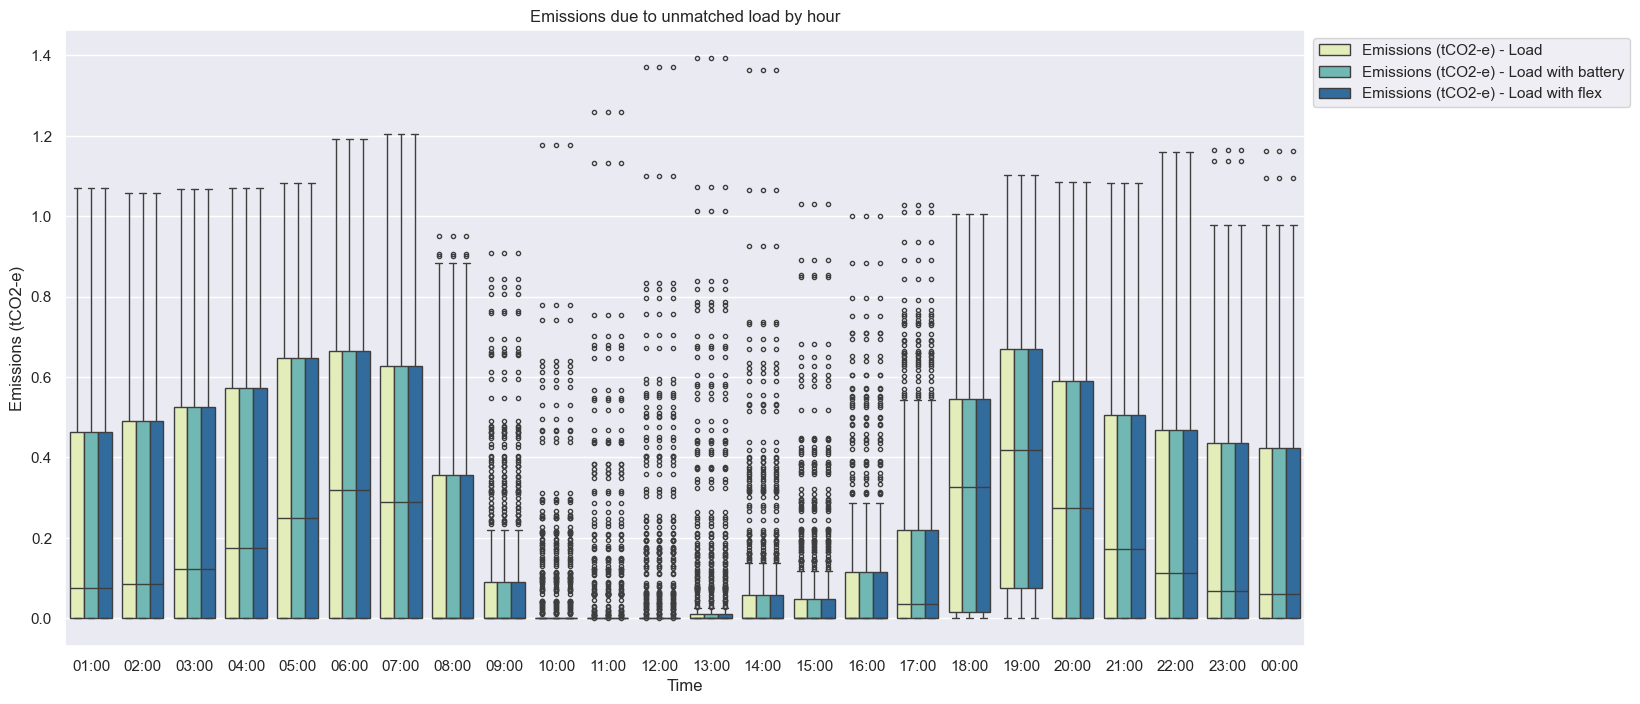

In [25]:
charts.plot_emissions_bw(load_and_gen_data=combined_data)

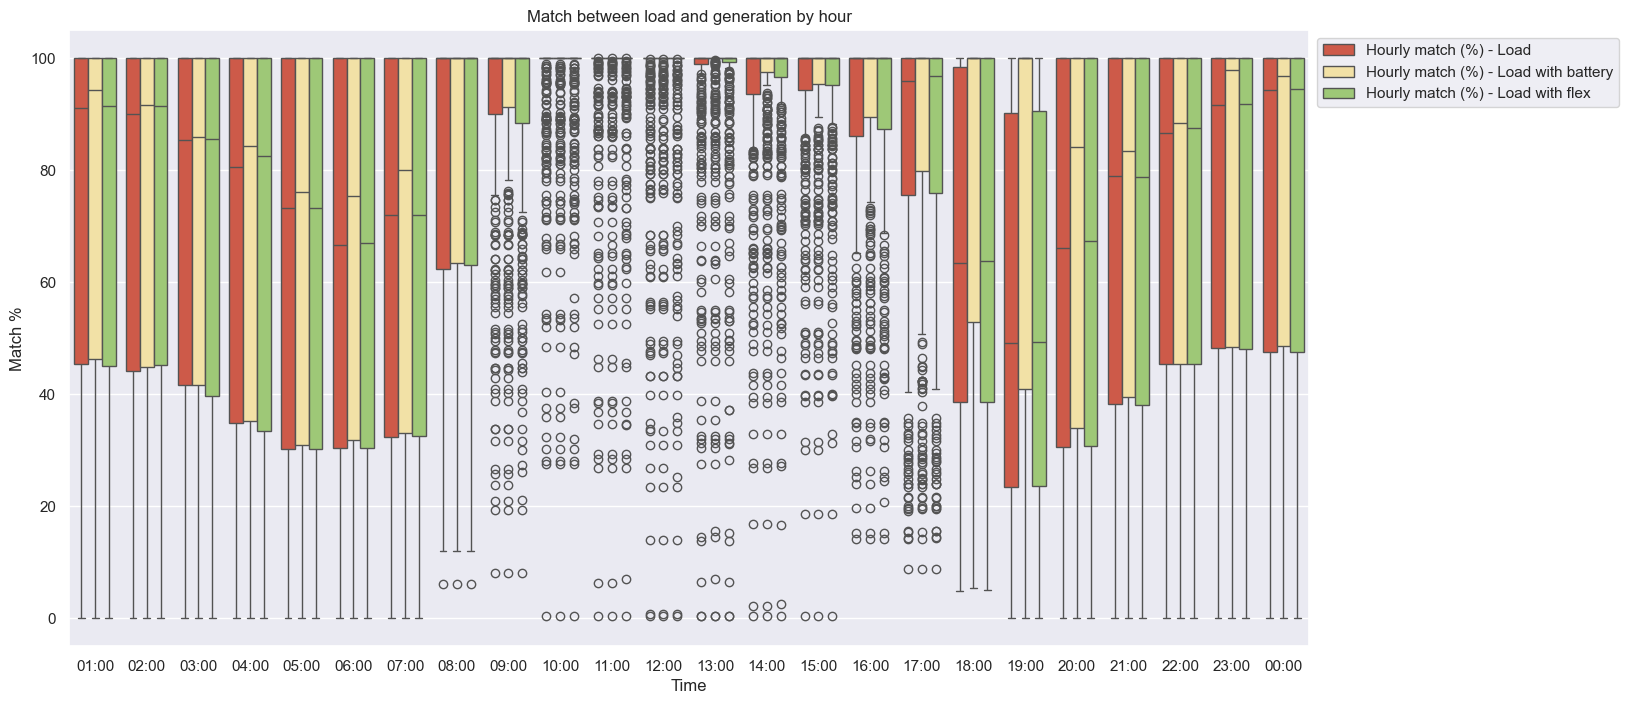

In [26]:
charts.plot_matching_bw(load_and_gen_data=combined_data)

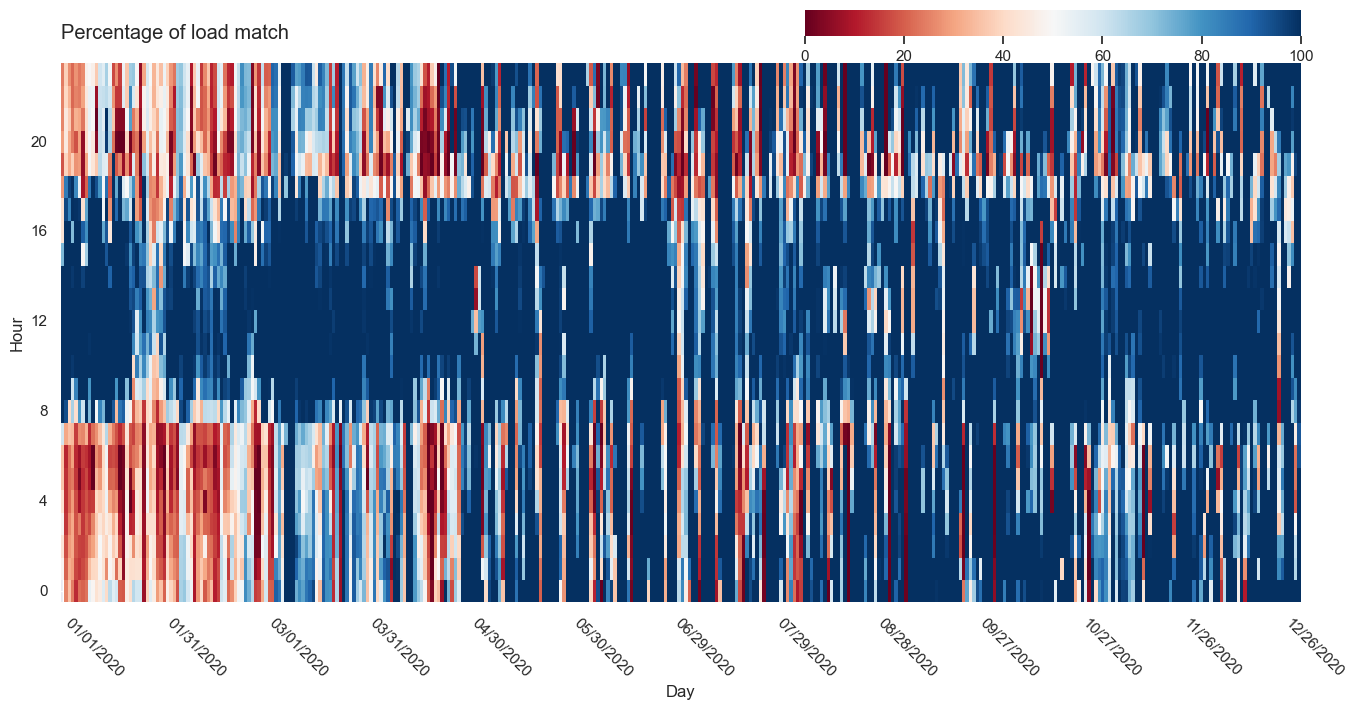

In [27]:
charts.plot_matching_heatmap(
    load_and_gen_data=combined_data, load_column_to_plot="Load"
)

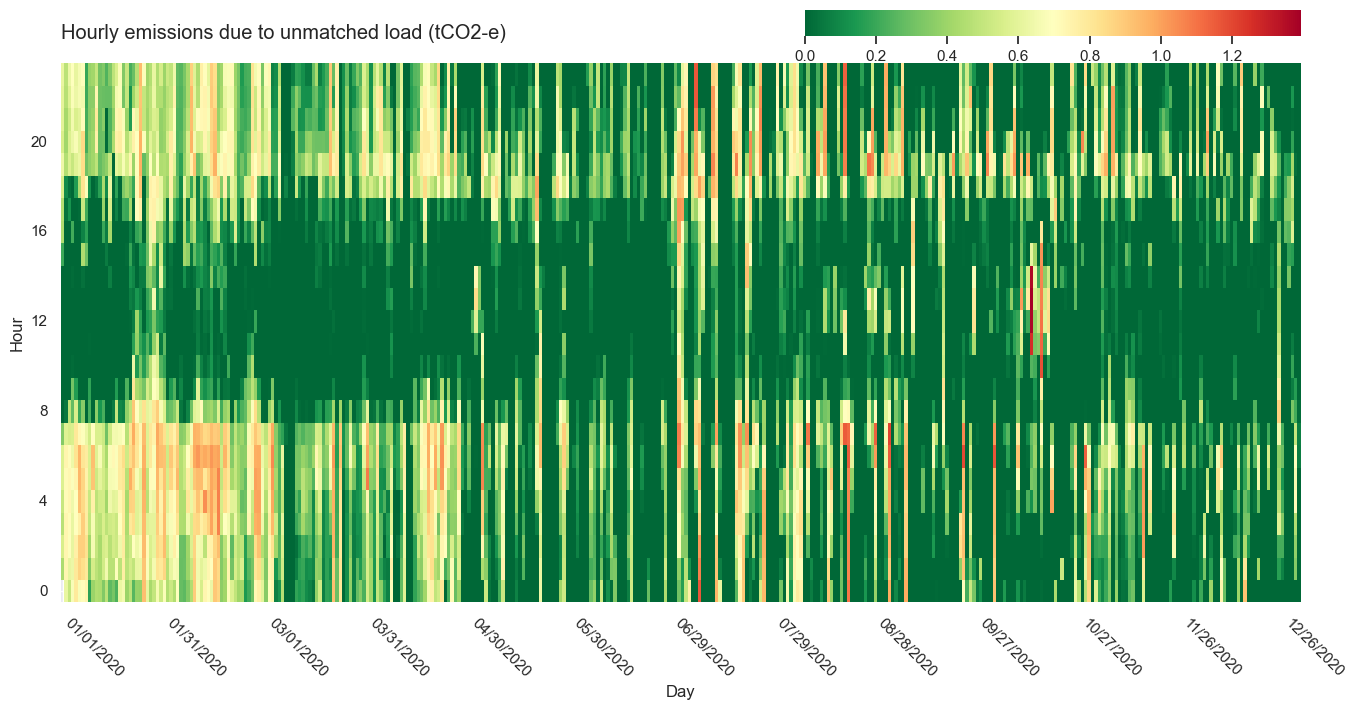

In [28]:
charts.plot_emissions_heatmap(
    load_and_gen_data=combined_data, load_column_to_plot="Load"
)